# Exploratory Data Analysis
by __Pawel Rosikiewicz__ 

---

![outliers_slide_01](images/Slide6.jpeg)

## __Main questions__

__basis__
* how many sequences do i have
* what is their lenght
* how many dupicates
* are sequences from mous and humans aligned?
* can i see missing data - what they are, and how to define missing data?

__data cleaning__
* can we remove some trash sequences?
* are these datasets boased in some ways, if yes how?
* what is the aa representaiotn across the seuqence?
* what si the difference between mouse and human datasets?

__advanced__
* can you see some major difference,s that yould be used to reduce input data?

## Setup
---

In [1]:
import os
import sys
import re # module to use regular expressions, 
import glob # lists names in folders that match Unix shell patterns
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mlp
import seaborn as sns
import scipy.stats as stats

from IPython.display import Image # to import one image and display in jupyter

In [2]:
# basedir
basedir = os.path.dirname(os.getcwd())
os.chdir(basedir)
sys.path.append(basedir)
print(basedir)

/Users/pawel/Desktop/activities/100__Projects/LTSM_for_Antibiodies/LTSM_for_Antibodies


In [3]:
# paths
PATH_data_raw     = os.path.join(basedir, "data/raw")
PATH_data_interim = os.path.join(basedir, "data/interim")
PATH_results      = os.path.join(basedir, "data/results")
PATH_models       = os.path.join(basedir, "models")

In [9]:
# load project configs
from src.configs.filenames_and_colors import organisms, colors 
from src.configs.filenames_and_colors import filenames_aa_seq, filenames_aa_seq_vlen

# load custom functions
from src.utils.eda_helpers import aa_seq_len_hist
from src.utils.eda_helpers import aa_seq_qc # QC table on loaded qq-seq data
from src.utils.eda_helpers import load_aa_sequences # loads sequences and provides basic info on data
from src.utils.eda_helpers import Load_data_for_ml # more advanced loader, that provides data labels, test and train data
from src.utils.eda_helpers import calc_aa_perc_per_pos # returns perc of aa/positon
from src.utils.eda_helpers import calc_aa_number_per_pos # -||- and their number/position + filter t our noise with % threshold

## Step 1. Load the data
* two alternative types of inpout files are avialble:
    * .txt files with AA sequences for human and mice antibodies, 
    * vlen.txt - the same content, but with aligned AA sequesnes, wiht gaps, indicated with "-"
    


-----------------------------------------------
all data human
-----------------------------------------------
. shape: (510101,)
. unique el: (510101,)
. non-unique el: 0
. max nr of duplicates: None
. mean seq len:, 150.0±0.0
. examples


0    -EVRLTES-GGGLVQPGGSLRLSCAASG-FPFGD-----YAMHWVR...
1    -DVQLVDS-GGGLVQPGGSLRLSCAASG-FTVSN-----SYIHWVR...
Name: 0, dtype: object

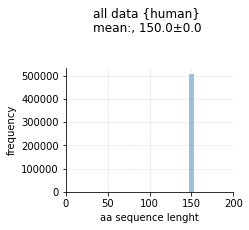


-----------------------------------------------
all data mouse
-----------------------------------------------
. shape: (500000,)
. unique el: (499976,)
. non-unique el: 24
. max nr of duplicates: 4
. mean seq len:, 150.0±0.0
. examples


0    -QVQLKQS-GAELVRPGSSVKLSCKDSS-FAFMA-----SAMHWVK...
1    -EVQLQQS-GPELVKPGASVKMSCKASG-YTFTD-----YYMHWVK...
Name: 0, dtype: object

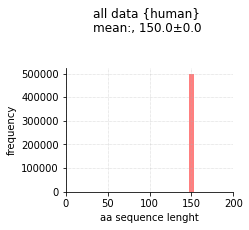

In [10]:
filenames_to_use = filenames_aa_seq
aa_seq_data_dct = dict()
aa_perc_per_pos_dct = dict()

# perform showrt qc on your sequences, 
for file_type in organisms:  

    # check for duplicates in all human data
    for i, fname in enumerate(filenames_to_use[file_type]):
        if i==0:
            data = load_aa_sequences(PATH_data_raw, fname) 
        else:
            data = pd.concat([data, load_aa_sequences(PATH_data_raw, fname)], axis=0)
            data.reset_index(drop=True, inplace=True)
        #print(data.shape)

    # qc on all the data
    aa_seq_qc(data, f"all data {file_type}")
    aa_seq_len_hist(data, "all data {human}", limits=(0, 200), color=colors[file_type])
    
    # safe the results
    aa_seq_data_dct[file_type]=data

    # calc_aa_perc_per_pos  
    aa_perc_per_pos_dct[file_type]=calc_aa_perc_per_pos(data)

### create heatmap with differences in aa-seq between human and mouse 
__Fig. desription__
* histogram shows the difference in percentage of aa presence at each postions in mouse and human aa antibodies sequences
* values lower then zero (red), shows aa present more often in mouse aa sequences
* values greater then zero (blue), shows aa present more often in human aa sequences
* important - white color is placed for all aa that are either, absent at a given positons in both human and mouse sequences, or they have the same percentage  in aa-seq data at that postion.

__OBSERVATIONS__
* approximately half of the postions, have aa that are more often found in either human or mouse
* there data suggest that mouse may sibstitute aa with simila funciton and tstructure at some postions, eg there is a group of postions with Lysine (K) in human aa-seqences, whereas the same postions in mouse sequences have more often Arginine (R)

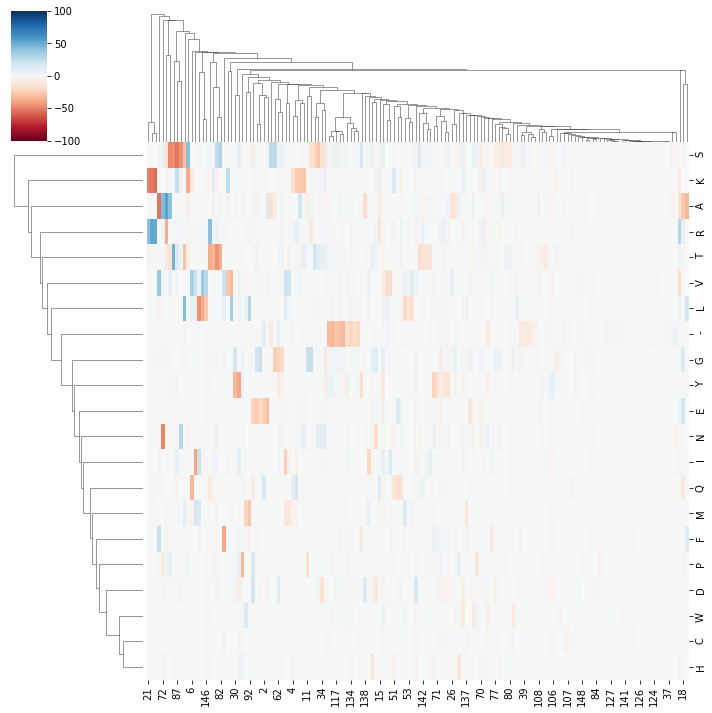

In [8]:
# create heatmap with differences in aa-seq between human and mouse 
aa_perc_diff = aa_perc_per_pos_dct[file_types[0]]-aa_perc_per_pos_dct[file_types[1]]
sns.clustermap(aa_perc_diff, vmin=-100, vmax=100, cmap="RdBu")

__aa properties table from Wikipedia for easier intepretation of some aa substitusion__

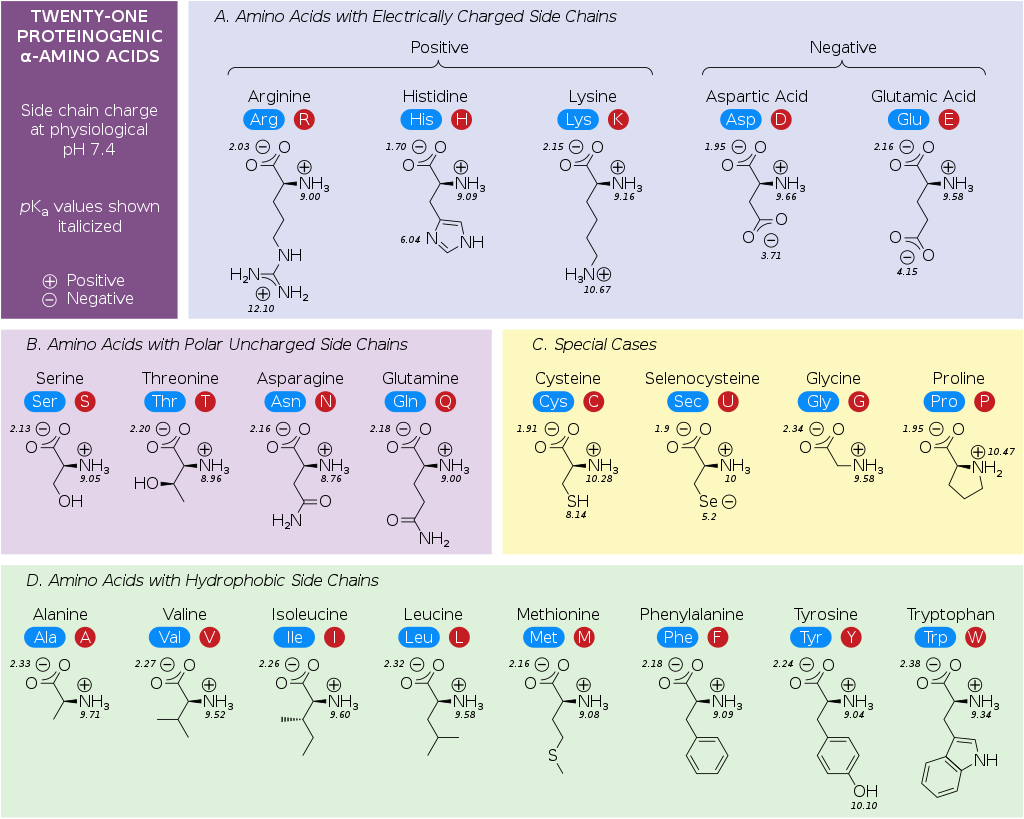

In [9]:
Image(filename="./images/ProteinogenicAminoAcids.svg.png",  width=400)

__plot AA/gap percentage on each positon in sequences from human and mouse__ 
* beside, EDA goal, I wish to know if I havent made some mistakes, ie, whther there are real differences that could be observed or I am looking only on artifact form some errors in my code

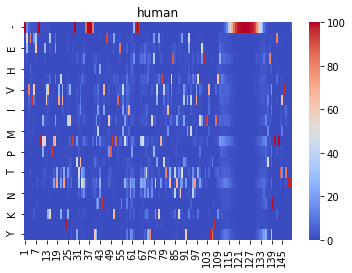

In [59]:
h = sns.heatmap(aa_perc_per_pos_dct[file_types[0]], vmin=0, vmax=100, cmap="coolwarm");
h.set_title(file_types[0]);

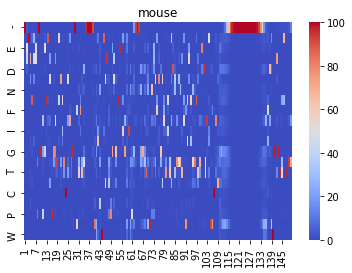

In [60]:
h = sns.heatmap(aa_perc_per_pos_dct[file_types[1]], vmin=0, vmax=100, cmap="coolwarm");
h.set_title(file_types[1]);

### __check how many different aa are expected to find per postion in human and mounse aa-seqeunce data__

__OBSERVATIONS__
* interestingly, nearly all positions in aa-sequence form humans and mouse, may have alll or almost all different nulcoeitdes . there are relatively low number of highly conserved positons in AA-seq from humans and mouse origine.

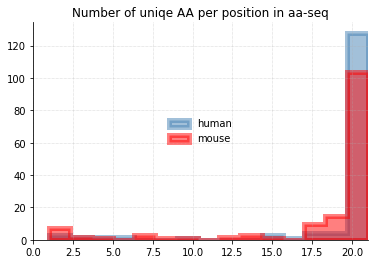

In [14]:
# perform showrt qc on your sequences, 
unique_aa_perc_dct = dict()

# extract the data, and plot hist, for each organism
for file_type in organisms:  
    # get the data for each organism
    s = aa_seq_data_dct[file_type]

    # find number of unique aa/positon
    unique_aa_counts, unique_aa_perc = calc_aa_number_per_pos(s)
    unique_aa_perc_dct[file_type] = unique_aa_perc
    
    # create hist
    plt.hist(unique_aa_counts, bins=15, histtype="stepfilled", label=file_type,
             color=colors[file_type], edgecolor=colors[file_type], linewidth=5, alpha=0.5)
    plt.title("Number of uniqe AA per position in aa-seq") 
    plt.xlim(0, 21)
    plt.grid(lw=0.5, ls=":")
    sns.despine()
    plt.legend(frameon=False, loc="center")
    

__it was suprising giving large insertions in aa-seqiuences, in human and mouse data from 115 to 130 (approx) aa__
* thus I check source data manually, 
* you can see that, the gap is replaces in small number of sequences with AA at most of the postions, 
* and that the postions are rarely having only one AA, or gap

In [11]:
# call for human or mouse data use to create histogram in the above, from postions 120-125
unique_aa_perc_dct[file_type][120:127]

[-    99.9970
 T     0.0010
 I     0.0006
 D     0.0002
 S     0.0002
 G     0.0002
 L     0.0002
 F     0.0002
 V     0.0002
 Y     0.0002
 Name: 121, dtype: float64,
 -    99.9998
 L     0.0002
 Name: 122, dtype: float64,
 -    100.0
 Name: 123, dtype: float64,
 -    100.0
 Name: 124, dtype: float64,
 -    100.0
 Name: 125, dtype: float64,
 -    99.9998
 Y     0.0002
 Name: 126, dtype: float64,
 -    99.9990
 V     0.0006
 I     0.0002
 F     0.0002
 Name: 127, dtype: float64]

In [11]:
# set threshold
'''it is min. percentage of aa-seq with a given aa, at a given positon
    if below, that aa, is considered an error/noise and removed, 
'''
tr = 1 # ie only aa with %/positon >=1% will be used

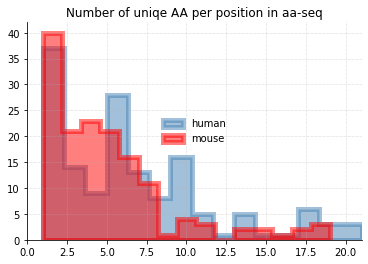

In [13]:
# dct for resulst
unique_aa_perc_dct = dict()

# extract the data, and plot hist, for each organism
for file_type in organisms:  
    # get the data for each organism
    s = aa_seq_data_dct[file_type]

    # find number of unique aa/positon
    unique_aa_counts, unique_aa_perc = calc_aa_number_per_pos(s, tr=tr)
    unique_aa_perc_dct[file_type] = unique_aa_perc
    
    # create hist
    plt.hist(unique_aa_counts, bins=15, histtype="stepfilled", label=file_type,
             color=colors[file_type], edgecolor=colors[file_type], linewidth=5, alpha=0.5)
    plt.title("Number of uniqe AA per position in aa-seq") 
    plt.xlim(0, 21)
    plt.grid(lw=0.5, ls=":")
    sns.despine()
    plt.legend(frameon=False, loc="center")